In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
path = '/content/drive/My Drive/custom_data/'

In [ ]:
import pandas as pd
ori_export = pd.read_csv(path+'exports.csv')
ori_umcsent = pd.read_csv(path+'UMCSENT.csv', skiprows= 10 ,dtype = {'observation_date':str,'UMCSENT':float})
ori_epu = pd.read_csv(path+'EPU.csv')

In [ ]:
ori_export.head()

,기간,수출건수,수출금액,수입건수,수입금액,무역수지
0,총계,"137,838,022","8,854,654,327","249,266,008","8,067,363,795","787,290,532"
1,2000.01,"258,896","12,162,425","246,432","12,594,623","-432,198"
2,2000.02,"256,293","12,676,042","242,907","12,023,652","652,390"
3,2000.03,"313,910","14,429,703","293,016","14,212,011","217,692"
4,2000.04,"293,464","13,522,040","268,239","13,344,532","177,508"


In [ ]:
ori_umcsent.head()

,observation_date,UMCSENT
0,2000-01-01,112.0
1,2000-02-01,111.3
2,2000-03-01,107.1
3,2000-04-01,109.2
4,2000-05-01,110.7


In [ ]:
ori_epu.head()

,Year,Month,Three_Component_Index,News_Based_Policy_Uncert_Index
0,1985,1.0,125.224739,103.748802
1,1985,2.0,99.020813,78.313202
2,1985,3.0,112.190506,100.761482
3,1985,4.0,102.811325,84.778870
4,1985,5.0,120.082725,98.053658


In [ ]:
for i in ori_export.columns:
  if i != '기간':
    ori_export[i] = pd.to_numeric(ori_export[i].str.replace(pat=r'[^A-Za-z0-9]', repl= '', regex=True),downcast='float')

In [ ]:
f1 = ori_epu['Three_Component_Index'][180:430]
f1.index = np.arange(0,250)
trn_y = ori_export['수출금액'][1:251]
trn_y.index = np.arange(0,250)
DATA = pd.concat([ori_umcsent['UMCSENT'][:250],f1,trn_y],axis=1,ignore_index=True)
DATA.index = ori_export['기간'][1:251]

In [ ]:
DATA.columns = ['umcsent','epu','exports']

In [ ]:
DATA.head()

,umcsent,epu,exports
기간,,,
2000.01,112.0,89.201538,12162425.0
2000.02,111.3,77.601395,12676042.0
2000.03,107.1,77.548309,14429703.0
2000.04,109.2,76.059227,13522040.0
2000.05,110.7,97.986206,14636755.0


In [ ]:
def prepared_data(data,win,h,model_name):
  x = data.to_numpy()
  x = (x-np.min(x,axis=0))/(np.max(x,axis=0)-np.min(x,axis=0))

  if model_name == 'fc_model': #nc
    X = np.hstack([x[1:-1],x[:-(h)]])
    Y = x[(h):]
    return (X,Y)
  else:
    X = np.zeros((x.shape[0]-win-h,win,x.shape[1]))
    Y = np.zeros((x.shape[0]-win-h,x.shape[1]))
    for i in range(win,x.shape[0]-h):
      Y[i-win] = x[i+h-1,:]
      X[i-win] = x[(i-win):i,:]
    return (X,Y )

In [ ]:
(X,Y) = prepared_data(DATA,win=None,h=2,model_name='fc_model')

In [ ]:
print(X[0])
print(X[1])

[0.98765432 0.06955932 0.03748973 1.         0.10911553 0.02584103]
[0.91358025 0.0693783  0.07726232 0.98765432 0.06955932 0.03748973]


In [ ]:
from keras import models
from keras import layers

def build_model(layer_n,feature_n,act_f='relu'):
  model = models.Sequential()
  model.add(layers.Dense(feature_n,activation=act_f,
                         input_shape=(None,6)))
  for i in range(layer_n):
    model.add(layers.Dense(feature_n,activation=act_f))
  model.add(layers.Dense(3))
  model.compile(optimizer='adam',loss='mse',metrics=['mae'])
  return model

In [ ]:
model = build_model(2,64,'relu')
model.fit(X[:150],Y[:150],verbose=0,epochs=10)

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, None, 64)          448       
_________________________________________________________________
dense_98 (Dense)             (None, None, 64)          4160      
_________________________________________________________________
dense_99 (Dense)             (None, None, 64)          4160      
_________________________________________________________________
dense_100 (Dense)            (None, None, 3)           195       
Total params: 8,963
Trainable params: 8,963
Non-trainable params: 0
_________________________________________________________________


In [ ]:
  x2 = DATA.to_numpy()
  x2 = (x2-np.min(x2,axis=0))/(np.max(x2,axis=0)-np.min(x2,axis=0))

In [ ]:
 def trans2data(data1,data2,time):
  data1 = data1[time]
  t = np.hstack([data2,data1])
  return t

In [ ]:
import keras
tree_n = 50

all_predicts = []
all_layer = []
all_feature = []
all_epoch = []
all_mse = []
all_mae = []
all_val_mse = []
all_val_mae = []

for i in range(tree_n):
  print('tree_n :',i+1)
  layer = np.random.randint(10, high=32, size=None, dtype=int)
  feature = np.random.randint(6, high=128, size=None, dtype=int)
  epoch_n = np.random.randint(15, high=50, size=None, dtype=int)
  all_layer.append(layer)
  all_feature.append(feature)
  all_epoch.append(epoch_n)

  result_tst = []
  model = build_model(layer_n=layer,feature_n=feature,act_f='relu')
  callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,mode='auto')
  for j in range(20):
    hist_model = model.fit(X[10+5*j:148+5*j],Y[10+5*j:148+5*j],epochs=epoch_n,
                           validation_data = (X[5*j:10+5*j],Y[5*j:10+5*j]),
                           callbacks = [callback],verbose=0,shuffle=True)
    y_pred = X[148+5*j-1]
    for k in range(5):
      y_pred = model.predict(y_pred[np.newaxis])
      result_tst.append(y_pred)
      y_pred = trans2data(x2,y_pred.reshape(-1),time=(150-2+5*j))

  all_predicts.append(result_tst)
  all_mse.append(hist_model.history['loss'])
  all_mae.append(hist_model.history['mae'])
  all_val_mse.append(hist_model.history['val_loss'])
  all_val_mae.append(hist_model.history['val_mae'])

In [ ]:
all_predicts = np.array(all_predicts)
all_layer = np.array(all_layer)
all_feature = np.array(all_feature)
all_epoch = np.array(all_epoch)
all_mse = np.array(all_mse)
all_mae = np.array(all_mae)
all_val_mse = np.array(all_val_mse)
all_val_mae = np.array(all_val_mae)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  im

In [ ]:
all_predicts.shape

(50, 100, 1, 3)

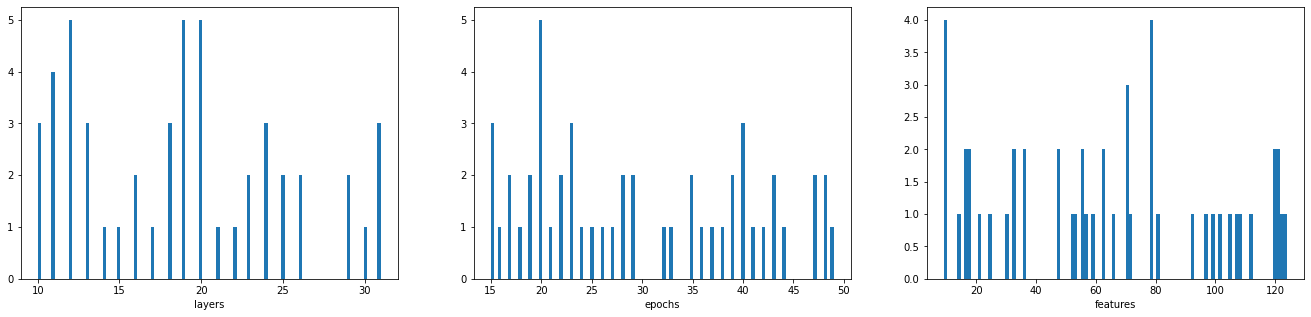

In [ ]:
df1 = all_layer.copy()
df2 = all_epoch.copy()
df3 = all_feature.copy()

plt.figure(figsize=(23,5))
plt.subplot(1,3,1)
plt.hist(df1,bins=100)
plt.xlabel('layers')

plt.subplot(1,3,2)
plt.hist(df2,bins=100)
plt.xlabel('epochs')

plt.subplot(1,3,3)
plt.hist(df3,bins=100)
plt.xlabel('features')

plt.show()

In [ ]:
from scipy.stats import t

sample = all_predicts.copy()
sample_mean = sample.mean(axis=0)
sample_std = sample.std(axis=0)

df = tree_n-1
t_ = t(df)
t_05 = t_.ppf(0.95)
L_= sample_mean - t_05*(sample_std/np.sqrt(tree_n))
U_= sample_mean + t_05*(sample_std/np.sqrt(tree_n))

df = tree_n-1
t_ = t(df)
t_10 = t_.ppf(0.90)
L__= sample_mean - t_05*(sample_std/np.sqrt(tree_n))
U__= sample_mean + t_05*(sample_std/np.sqrt(tree_n))

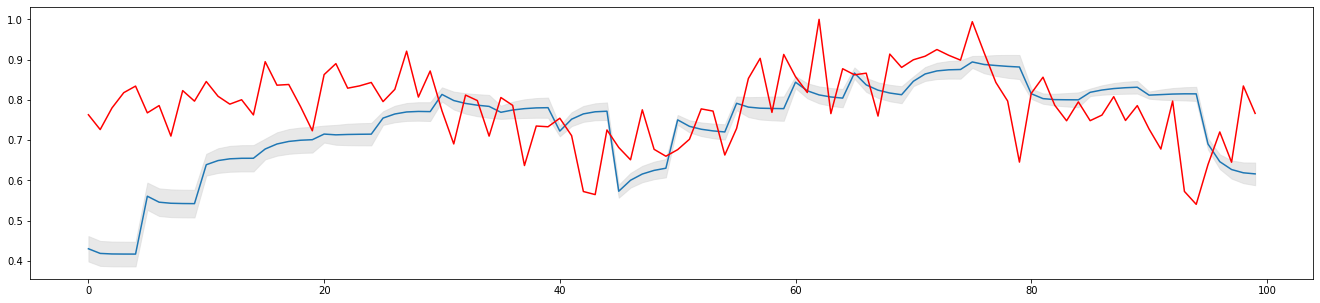

In [ ]:
L = L_.copy()
U = U_.copy()
L2 = L__.copy()
U2 = U__.copy()

MU = sample_mean.copy().reshape(-1,3)

L = L.reshape(-1,3)
U = U.reshape(-1,3)
L2 = L2.reshape(-1,3)
U2 = U2.reshape(-1,3)

days = np.arange(100)
asw_y = Y[-100:]
plt.figure(figsize=(23,5))
plt.plot(days,MU[:,2],days,asw_y[:,2],'r-')
#plt.fill_between(days, L, U, color='green', alpha=0.5)
plt.fill_between(days, L2[:,2], U2[:,2], color='lightgray', alpha=0.5)
plt.show()

#최적화

In [ ]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(60,'ReLU',input_shape=(None,6)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(30,'ReLU'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3))
model.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 60)          420       
_________________________________________________________________
dropout (Dropout)            (None, None, 60)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 30)          1830      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 30)          0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 3)           93        
Total params: 2,343
Trainable params: 2,343
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def trans2data(data1,data2,time):
 data1 = data1[time]
 t = np.hstack([data2,data1])
 return t

In [ ]:
x2 = DATA.to_numpy()
x2 = (x2-np.min(x2,axis=0))/(np.max(x2,axis=0)-np.min(x2,axis=0))

In [ ]:
import tensorflow as tf
result_tst = []
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,mode='auto')
for j in range(20):
  hist_model = model.fit(X[10+5*j:148+5*j],Y[10+5*j:148+5*j],epochs=10,
                         validation_data = (X[5*j:10+5*j],Y[5*j:10+5*j]),
                         callbacks = [callback],verbose=0,shuffle=True)
  y_pred = X[148+5*j-1]
  for k in range(5):
    y_pred = model.predict(y_pred[np.newaxis])
    result_tst.append(y_pred)
    y_pred = trans2data(x2,y_pred.reshape(-1),time=(150-2+5*j))

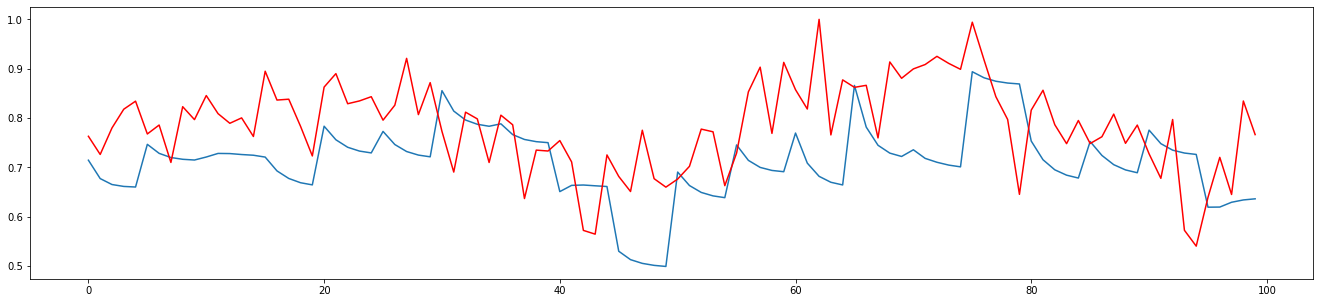

In [ ]:
y_ = np.array(result_tst).reshape(-1,3)[:,2]
asw_y = Y[-100:]
days = np.arange(100)
plt.figure(figsize=(23,5))
plt.plot(days, y_ , days,asw_y[:,2] ,'r')

In [ ]:
np.savetxt(path+'DNN_0710.txt', y_, fmt='%.6f', delimiter=',')

#DNN 실험실

In [ ]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(60,'ReLU',input_shape=(None,6)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(30,'ReLU'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3))
model.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,mode='auto')
hist_model = model.fit(X[10:148],Y[10:148],epochs=10,
                       validation_data = (X[:10],Y[:10]),
                       callbacks = [callback],verbose=0,shuffle=True)

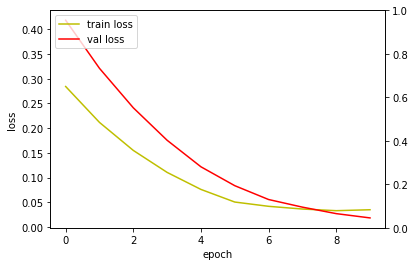

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist_model.history['loss'], 'y', label='train loss')
loss_ax.plot(hist_model.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

#acc_ax.plot(hist.history['mae'], 'b', label='train mae')
#acc_ax.plot(hist.history['val_mae'], 'g', label='val mae')
#acc_ax.set_ylabel('mae')
#acc_ax.legend(loc='upper left')

plt.show()